# Urinary Stone Challenge
# - MOAI MCRC Deep Learning Challenge for urinary stone challenge

In [1]:
# Checking data
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('../input/urinary-stone-challenge/DataSet'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

../input/urinary-stone-challenge/DataSet/Train/DCM/107.dcm
../input/urinary-stone-challenge/DataSet/Train/Label/206.png
../input/urinary-stone-challenge/DataSet/Valid/DCM/634.dcm
../input/urinary-stone-challenge/DataSet/Valid/Label/609.png
../input/urinary-stone-challenge/DataSet/Test/DCM/896.dcm


In [2]:
# Image shape
imgHeight = 512
imgWidth = 512
imgChannels = 1

# Random seed
seed = 1234

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 3e-4
EPOCHS = 100

In [3]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import pydicom
import cv2

from keras import layers, optimizers
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import (Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D,
UpSampling3D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import keras.backend as K
import tensorflow as tf

# EDA & Data preprocessing

In [4]:
# To load files for train
filelist = sorted(glob.glob('../input/urinary-stone-challenge/DataSet/Train/DCM/*.dcm'))
scans=[]
for dicom_file in filelist:
    scan = pydicom.read_file(dicom_file)
    scans.append(scan)

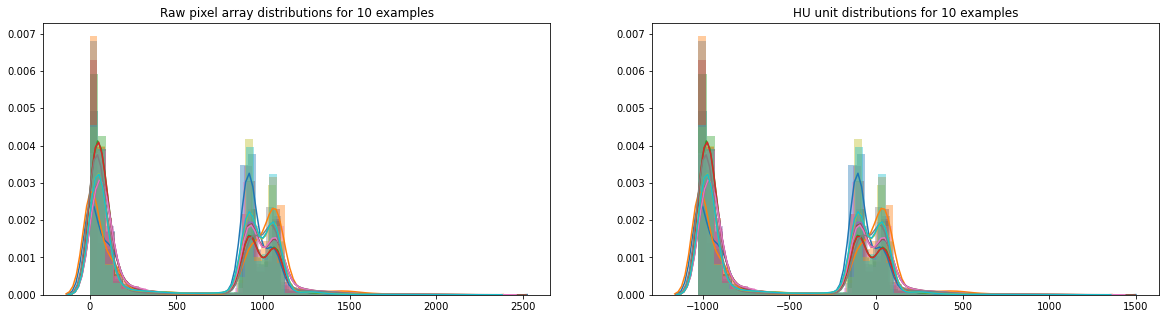

In [5]:
# Let's see the distributions of Raw pixel array and HU unit
fig, ax = plt.subplots(1,2,figsize=(20,5))
for n in range(10):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

In [6]:
def set_outside_scanner_to_air(raw_pixelarrays):
    # In this competition, we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

In [7]:
def set_to_stone(raw_pixelarrays):
    # We find the threshold to get urinary stone and other bone structures.
    # We can remove some soft organs with this threshold.
    raw_pixelarrays[raw_pixelarrays <= 1100] = 0   
    return raw_pixelarrays

In [8]:
# To normalize the image
def normalize(img):
    arr = img.copy().astype(np.float)
    M = np.float(np.max(img))
    if M != 0:
        arr *= 1./M
    return arr

In [9]:
# Image preprocessing

def preprocess(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # remove bed-mat
    images[:,330:,:]=0

    # remove other noise
    images[:,:160,:]=0
    images[:,:,400:]=0
    images[:,:,:112]=0

    # apply thresholds.
    images = set_outside_scanner_to_air(images)
    images = set_to_stone(images)
    
    # Normalize
    for img in images:
        normalize(img)
    
    return np.array(images, dtype=np.int16)

In [10]:
p_scans = preprocess(scans)
p_scans.shape

(600, 512, 512)

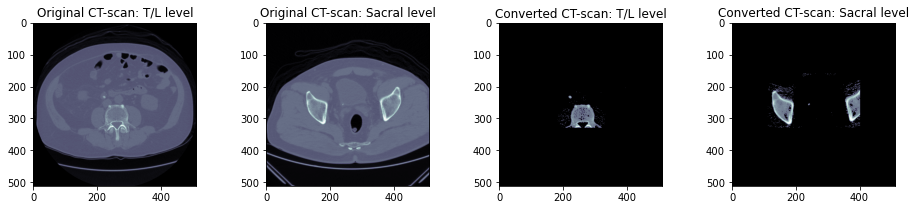

In [11]:
# To show images after preprocessing
# We find the different types of images (based on the shape of spine)

fig, ax = plt.subplots(1,4,figsize=(16,3))
ax[0].set_title("Original CT-scan: T/L level")
ax[0].imshow(scans[0].pixel_array, cmap="bone")
ax[1].set_title("Original CT-scan: Sacral level")
ax[1].imshow(scans[300].pixel_array, cmap="bone")

ax[2].set_title("Converted CT-scan: T/L level")
ax[2].imshow(p_scans[0], cmap="bone")
ax[3].set_title("Converted CT-scan: Sacral level")
ax[3].imshow(p_scans[300], cmap="bone")

In [12]:
images = np.expand_dims(p_scans,axis=-1)
images.shape

(600, 512, 512, 1)

In [13]:
## To create a one hot encoded matrix (label) from a png for per pixel classification
from cv2 import imread

labellist = sorted(glob.glob('../input/urinary-stone-challenge/DataSet/Train/Label/*.png'))

labels=[]
n_classes = 2
for png_file in labellist:
    p_image = imread(png_file,0)
    one_hot = np.zeros((p_image.shape[0],  p_image.shape[1], n_classes))
    for i, unique_value in enumerate(np.unique(p_image)):
        one_hot[:, :, i][p_image == unique_value] = 1
    labels.append(one_hot)

In [14]:
labels = np.array(labels)
labels.shape

(600, 512, 512, 2)

In [15]:
# To load the valid images
valid_filelist = sorted(glob.glob('../input/urinary-stone-challenge/DataSet/Valid/DCM/*.dcm'))


### valid_filelist contains all *.dcm files from Valid folder
valid_scans=[]
for dicom_file in valid_filelist:
    v_scan = pydicom.read_file(dicom_file)
    valid_scans.append(v_scan)

valid_images = preprocess(valid_scans)
valid_images = np.expand_dims(valid_images,axis=-1)
valid_images.shape

(100, 512, 512, 1)

In [16]:
# To load the valid labels

valid_labellist = sorted(glob.glob('../input/urinary-stone-challenge/DataSet/Valid/Label/*.png'))
### valid_labellist contains all *.png files from Valid folder
valid_labels=[]
n_classes = 2
for v_png_file in valid_labellist:
    v_p_image = imread(v_png_file,0)
    v_one_hot = np.zeros((v_p_image.shape[0], v_p_image.shape[1], n_classes))
    for i, unique_value in enumerate(np.unique(v_p_image)):
        v_one_hot[:, :, i][v_p_image == unique_value] = 1
    valid_labels.append(v_one_hot)
valid_labels = np.array(valid_labels)
valid_labels.shape

(100, 512, 512, 2)

# Build Model

In [17]:
# We build the UNet with ResBlock for Semantic Segmentation


def res_unet(filter_root, depth, n_class=2, input_size=(512, 512, 1), activation='relu', batch_norm=True, final_activation='softmax'):
    
    inputs = Input(input_size)
    x = inputs
    # Dictionary for long connections
    long_connection_store = {}

    if len(input_size) == 3:
        Conv = Conv2D
        MaxPooling = MaxPooling2D
        UpSampling = UpSampling2D
    elif len(input_size) == 4:
        Conv = Conv3D
        MaxPooling = MaxPooling3D
        UpSampling = UpSampling3D

    # Down sampling
    for i in range(depth):
        out_channel = 2**i * filter_root

        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="Identity{}_1".format(i))(x)

        # First Conv Block with Conv, BN and activation
        conv1 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_1".format(i))(x)
        if batch_norm:
            conv1 = BatchNormalization(name="BN{}_1".format(i))(conv1)
        act1 = Activation(activation, name="Act{}_1".format(i))(conv1)

        # Second Conv block with Conv and BN only
        conv2 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_2".format(i))(act1)
        if batch_norm:
            conv2 = BatchNormalization(name="BN{}_2".format(i))(conv2)

        resconnection = Add(name="Add{}_1".format(i))([res, conv2])

        act2 = Activation(activation, name="Act{}_2".format(i))(resconnection)

        # Max pooling
        if i < depth - 1:
            long_connection_store[str(i)] = act2
            x = MaxPooling(padding='same', name="MaxPooling{}_1".format(i))(act2)
        else:
            x = act2

    # Upsampling
    for i in range(depth - 2, -1, -1):
        out_channel = 2**(i) * filter_root

        # long connection from down sampling path.
        long_connection = long_connection_store[str(i)]

        up1 = UpSampling(name="UpSampling{}_1".format(i))(x)
        up_conv1 = Conv(out_channel, 2, activation='relu', padding='same', name="upConv{}_1".format(i))(up1)

        #  Concatenate.
        up_conc = Concatenate(axis=-1, name="upConcatenate{}_1".format(i))([up_conv1, long_connection])

        #  Convolutions
        up_conv2 = Conv(out_channel, 3, padding='same', name="upConv{}_2".format(i))(up_conc)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_1".format(i))(up_conv2)
        up_act1 = Activation(activation, name="upAct{}_1".format(i))(up_conv2)

        up_conv3 = Conv(out_channel, 3, padding='same', name="upConv{}_3".format(i))(up_act1)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_2".format(i))(up_conv2)

        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="upIdentity{}_1".format(i))(up_conc)

        resconnection = Add(name="upAdd{}_1".format(i))([res, up_conv2])

        x = Activation(activation, name="upAct{}_2".format(i))(resconnection)

    # Final convolution
    output = Conv(n_class, 2, padding='same', activation=final_activation, name='output')(x)

    return Model(inputs, outputs=output, name='Res-UNet')

In [18]:
model = res_unet(8, 4, n_class=2, input_size=(imgHeight, imgWidth, imgChannels), activation='relu', batch_norm=False, final_activation='sigmoid')
model.summary()

Model: "Res-UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
Conv0_1 (Conv2D)                (None, 512, 512, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
Act0_1 (Activation)             (None, 512, 512, 8)  0           Conv0_1[0][0]                    
__________________________________________________________________________________________________
Identity0_1 (Conv2D)            (None, 512, 512, 8)  8           input_1[0][0]                    
___________________________________________________________________________________________

# Compile and Train

In [19]:
DATA_OUT_PATH = "./"

In [20]:
model_name = "stone_U-net"

# callbacks
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=7)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

./stone_U-net -- Folder create complete 



In [21]:
# Define loss function and metric.

adam = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, amsgrad=False)

iou = tf.keras.metrics.MeanIoU(
    num_classes=2)

In [22]:
# Compile model.
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=[iou]
)

In [23]:
# Train model.

model.fit(
    images, labels,
    validation_data = (valid_images, valid_labels),
    steps_per_epoch = len(labels)/BATCH_SIZE,
    validation_steps = len(valid_labels)/BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[earlystop_callback, cp_callback, reduce_lr])

Epoch 1/100
38/37 [==============================] - ETA: 0s - loss: 0.7444 - mean_io_u: 0.3470
Epoch 00001: val_loss improved from inf to 0.43470, saving model to ./stone_U-net/weights.h5
38/37 [==============================] - 12s 315ms/step - loss: 0.7444 - mean_io_u: 0.3470 - val_loss: 0.4347 - val_mean_io_u: 0.3762
Epoch 2/100
38/37 [==============================] - ETA: 0s - loss: 0.1435 - mean_io_u: 0.4171
Epoch 00002: val_loss improved from 0.43470 to 0.05456, saving model to ./stone_U-net/weights.h5
38/37 [==============================] - 10s 267ms/step - loss: 0.1435 - mean_io_u: 0.4171 - val_loss: 0.0546 - val_mean_io_u: 0.8849
Epoch 3/100
38/37 [==============================] - ETA: 0s - loss: 0.0447 - mean_io_u: 0.9223
Epoch 00003: val_loss improved from 0.05456 to 0.03179, saving model to ./stone_U-net/weights.h5
38/37 [==============================] - 10s 267ms/step - loss: 0.0447 - mean_io_u: 0.9223 - val_loss: 0.0318 - val_mean_io_u: 0.9392
Epoch 4/100
38/37 [====

# Prediction

In [24]:
# To load and preprocess the test images.
test_filelist = sorted(glob.glob('../input/urinary-stone-challenge/DataSet/Test/DCM/*.dcm'))

test_scans=[]
for dicom_file in test_filelist:
    t_scan = pydicom.read_file(dicom_file)
    test_scans.append(t_scan)

test_images = preprocess(test_scans)
test_images = np.expand_dims(test_images, axis=-1)
test_images.shape


(200, 512, 512, 1)

In [25]:
# Load best model
model.load_weights('./stone_U-net/weights.h5')

In [26]:
# Predict on test data
test_preds = model.predict(test_images)

In [27]:
# To test the prediction
new_test_number = 27

<function matplotlib.pyplot.show(*args, **kw)>

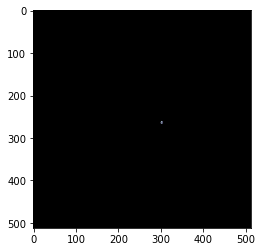

In [28]:
x = test_preds[new_test_number]
mask = np.argmax(x, axis=-1)
im = np.array(mask * 255, dtype = np.uint8)
threshed = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
plt.imshow(threshed, cmap ='bone')
plt.show

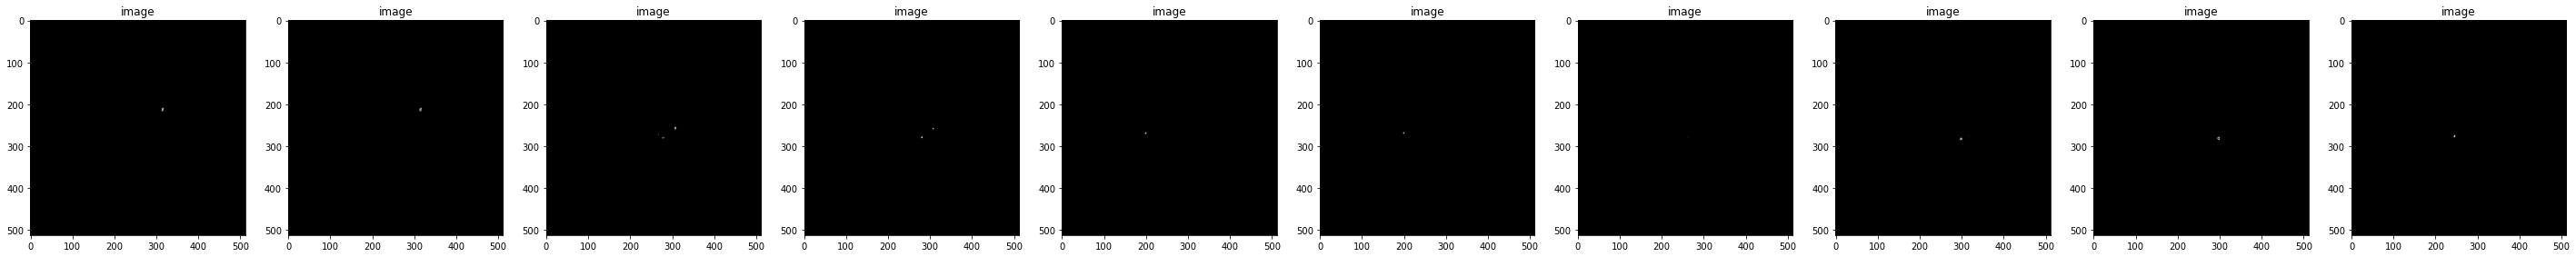

In [29]:
# Let's see other predictions.
fig, axes = plt.subplots(1,10, figsize=(50,100))
for i in range(0,10):
    x = test_preds[i]
    mask = np.argmax(x, axis=-1)
    im = np.array(mask * 255, dtype = np.uint8)
    threshed = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
    axes[i].imshow(threshed, cmap ='bone')
    axes[i].set_title('image')

In [30]:
!pip install -q tensorflow-io

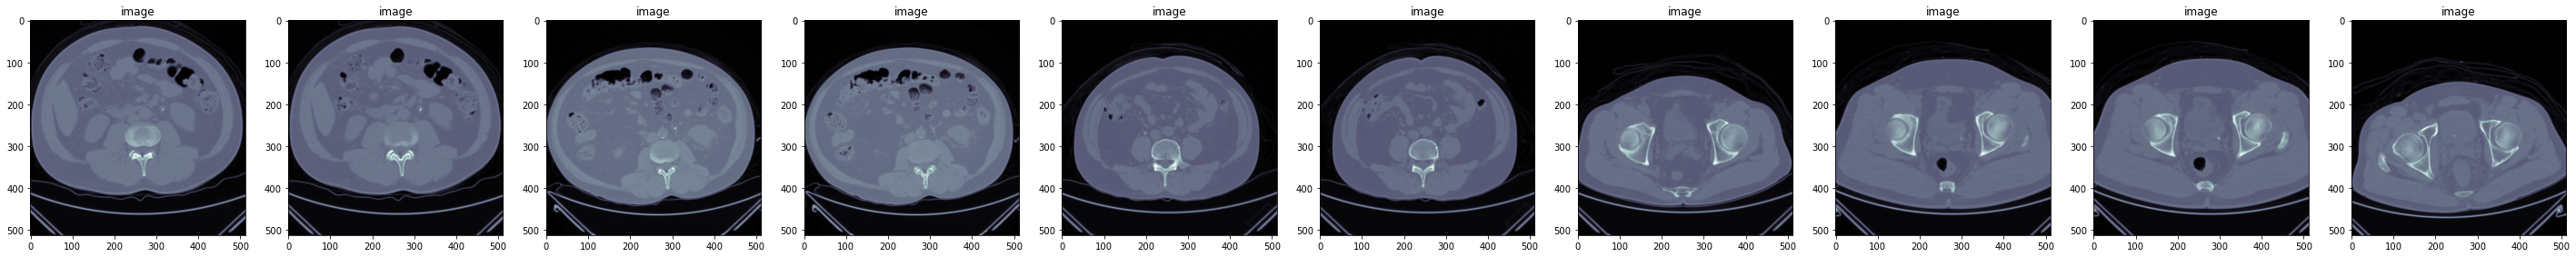

In [31]:
# Display original images of test data.
import tensorflow_io as tfio
test_inputs = []
for i in range(0,10):
    filename=test_filelist[i]
    image_bytes = tf.io.read_file(filename)
    test_input = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
    test_inputs.append(test_input)
fig, axes = plt.subplots(1,10, figsize=(50,100))
for i in range(0,10):
    axes[i].imshow(np.squeeze(test_inputs[i].numpy()), cmap='bone')
    axes[i].set_title('image')

# Submission

In [32]:
# Save the segmentation images.
from PIL import Image

output_path = './'

for i in range(len(test_filelist)):

    # To load file names..
    full_name = test_filelist[i].split('Test/DCM/')
    file_name = full_name[1]
    file_number = file_name.split('.')
    file_num = file_number[0] + '.png'
    path = os.path.join(output_path,file_num )

    # get images and save
    x = test_preds[i]
    mask = np.argmax(x, axis=-1)
    im = np.array(mask * 255, dtype = np.uint8)
    threshed = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
    pred = np.expand_dims(threshed, axis=-1)
    m_pred = tf.keras.preprocessing.image.array_to_img(pred)
    m_pred.save(path, format='png')

In [33]:
# To submit the valid data and iou score

valid_files = []
iou_scores = []

for i in range(len(valid_labellist)):
    # input file names
    full_name = valid_labellist[i].split('/Label/')
    file_name = full_name[1]
    valid_files.append(file_name)

    # input iou scores
    valid_images_1 = np.expand_dims(valid_images[i], axis=0)
    y_pred = model.predict(valid_images_1)
    valid_labels_1 = np.expand_dims(valid_labels[i], axis=0)
    score_tf = iou(y_pred, valid_labels_1)
    score_np = np.array(score_tf)
    score = np.asscalar(score_np)
    iou_scores.append(score)
print(len(valid_files))
print(len(iou_scores))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


100
100


In [34]:
# Make dataframe to submit
df = pd.DataFrame(list(zip(valid_files, iou_scores)), 
               columns =['valid_files', 'iou_scores'])
df.head()

,valid_files,iou_scores
0,601.png,0.991488
1,602.png,0.991486
2,603.png,0.991487
3,604.png,0.991488
4,605.png,0.991489


In [35]:
# Submission! (csv version)
df.to_csv('submission',index=False)